In [9]:
from feat import Feat
from pmlb import fetch_data
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
import numpy as np

dataset='690_visualizing_galaxy'
X, y = fetch_data(dataset,return_X_y=True)
X_t,X_v, y_t, y_v = train_test_split(X,y,train_size=0.75,test_size=0.25,random_state=42)

# fix the random state
random_state=11314

fest = Feat(pop_size=500,                                                                        
            gens=100,                  # maximum of 200 generations                            
            max_time=60,              # max time of 1 minute                                                         
            ml = "LinearRidgeRegression",   # use ridge regression (the default)                                                     
            sel='lexicase',                 # use epsilon lexicase selection (the default)                                                     
            surv='nsga2',                   # use nsga-2 survival (the defaut)                                                    
            max_depth=6,                    # constrain features to depth of 6                                                     
            max_dim=min([X.shape[1]*2,50]), # constrain representation dimensionality to 2x the feature space or 50                                                     
            random_state=random_state,                                                            
            backprop=True,                 # use gradient descent to optimize weights for 10 iterations                                                  
            iters=10,                                                                            
            n_threads=4,                   # max 1 threads                                                      
            verbosity=2,                   # verbose output                                                      
            logfile='feat_'+dataset+'.log', # save a log file of the training loss
            print_pop=1                    # print the final population
           ) 

# train the model
fest.fit(X_t,y_t)

# get the test score
test_score = {}
test_score['feat'] = mse(y_v,fest.predict(X_v))

# store the archive
str_arc = fest.get_archive()

print(fest.get_archive())

complexity,fitness,fitness_v,eqn
1	1825.754552	1790.440368	[x_1]
2	986.547630	824.236442	[x_3][x_1]
3	955.940666	790.250743	[x_2][x_1][x_3]
4	937.824253	756.152977	[x_3][x_1][x_0][x_2]
5	937.824253	756.153133	[x_1][x_1][x_3][x_2][x_0]
7	485.911845	472.255390	[x_3][sin(x_1)]
8	453.203395	411.248174	[x_2][x_3][sin(x_1)]
9	424.078397	391.675482	[x_0][sin(x_1)][x_2][x_3]
10	415.363548	395.724178	[sin(x_1)][x_1][x_3][x_2][x_0]
12	399.117556	372.875574	[(x_2+x_0)][(x_1-x_3)][sin(x_1)]
13	379.909018	362.780234	[tanh(x_0)][sin(x_1)][x_2]
14	357.904946	313.321607	[tanh(x_0)][sin(x_1)][x_2][x_3]
15	347.754302	386.422898	[sin(x_1)][x_2][(x_2/x_1)][x_3][x_0]
16	337.891960	364.756651	[x_3][x_1][(sqrt(|x_3|)*x_1)][x_0][x_2]
17	337.891957	364.760305	[x_1][x_3][(sqrt(|x_3|)*x_1)][x_0][x_1][x_2]
18	337.891956	364.761523	[(sqrt(|x_3|)*x_1)][x_1][x_1][x_1][x_3][x_0][x_2]
19	307.995012	326.265478	[x_1][tanh(x_0)][(sqrt(|x_3|)*x_1)]
20	268.212863	285.995149	[(sqrt(|x_3|)*x_1)][x_1][tanh(x_0)][x_2]
21	263.5

In [11]:
from feat import Feat
from pmlb import fetch_data
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.ensemble import RandomForestRegressor

X, y = fetch_data(dataset,return_X_y=True)
X_t,X_v, y_t, y_v = train_test_split(X,y,train_size=0.75,test_size=0.25,random_state=42)

rf = RandomForestRegressor(random_state=987039487)

rf.fit(X_t,y_t)

# test_score={}

test_score['rf'] = mse(y_v,rf.predict(X_v))


In [12]:
from feat import Feat
from pmlb import fetch_data
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.linear_model import ElasticNet

X, y = fetch_data(dataset,return_X_y=True)
X_t,X_v, y_t, y_v = train_test_split(X,y,train_size=0.75,test_size=0.25,random_state=42)

linest = ElasticNet()

linest.fit(X_t,y_t)

# test_score={}

test_score['elasticnet'] = mse(y_v,linest.predict(X_v))


In [13]:
test_score

{'feat': 255.40194234278906,
 'rf': 384.1365432098763,
 'elasticnet': 919.3515337699562}

best: 53
complexity [1, 2, 3, 4, 5, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33, 35, 36, 38, 39, 40, 41, 43, 46, 51, 53, 55, 57, 58]


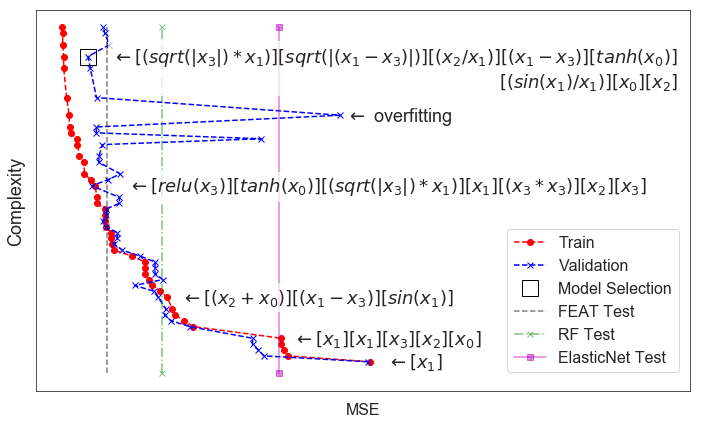

In [71]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
matplotlib.rcParams['figure.figsize'] = (10, 6)
%matplotlib inline 
sns.set_style('white')
complexity = []
fit_train = []
fit_val = []
fit_test = []
eqn = []
h = plt.figure(figsize=(10,6))

# store archive data from string
for s in str_arc.split('\n')[1:-1]:
    line = s.split('\t')
    complexity.append(int(line[0]))
    fit_train.append(float(line[1]))
    fit_test.append(float(line[2]))
    eqn.append(','.join(line[3:]))
    eqn[-1].replace('sqrt','\sqrt')

# plot archive points 
plt.plot(fit_train,complexity,'--ro',label='Train',markersize=6)
plt.plot(fit_test,complexity,'--bx',label='Validation')
best = np.argmin(np.array(fit_test))
print('best:',complexity[best])
plt.plot(fit_test[best],complexity[best],'sk',markersize=16,markerfacecolor='none',label='Model Selection')

# test score lines
y1 = -1
y2 = 58
plt.plot((test_score['feat'],test_score['feat']),(y1,y2),'--k',label='FEAT Test',alpha=0.5)
plt.plot((test_score['rf'],test_score['rf']),(y1,y2),'-.xg',label='RF Test',alpha=0.5)
plt.plot((test_score['elasticnet'],test_score['elasticnet']),(y1,y2),'-sm',label='ElasticNet Test',alpha=0.5)

print('complexity',complexity)
eqn[best] = '0)]$\n$'.join(eqn[best].split('0)]'))
xoff = 70
for e,t,c in zip(eqn,fit_test,complexity):
    if c in [1,5,12,31,43,53]:
        if c == 5 or c == 1: 
            t = t+200
        if c==complexity[best]: 
            tax = plt.text(t+18000,c-5,'$\leftarrow'+e+'$',size=18,horizontalalignment='right')
            tax.set_bbox(dict(facecolor='white', alpha=0.75, edgecolor='none'))
        elif c == 43:
            plt.text(t+xoff,c-1,'$\leftarrow$ overfitting',size=18)
        else:
            tax = plt.text(t+xoff,c-1,'$\leftarrow'+e+'$',size=18)
            tax.set_bbox(dict(facecolor='white', alpha=0.75, edgecolor='none'))

l = plt.legend(prop={'size': 16},loc=[0.72,0.05])
plt.xlabel('MSE',size=16)
# plt.gca().set_ylim(10,200)
plt.gca().set_xlim(150,right=20000)
# plt.gca().set_yscale('log')
plt.gca().set_xscale('log')

# plt.ylim(y1,y2)
plt.gca().set_yticklabels('')
plt.gca().set_xticklabels('')

plt.ylabel('Complexity',size=18)
h.tight_layout()
h.savefig('archive_example.svg')

plt.show()

In [138]:
model = fest.get_model()
for m in model.split('\n')[1:-1]:
    phi = m.split('\t')[0].replace('tanh','\\tanh').replace('*',' \\cdot ')
    beta = m.split('\t')[1]
    print('$'+phi+'$','&',round(float(beta),1),end=' \\\\\n')

$\tanh(x_1)$ & 2953.8 \\
$x_1$ & 1961.5 \\
$(x_3^2)$ & 329.0 \\
$\tanh(x_0)$ & -318.5 \\
$((x_1 \cdot x_0) \cdot (x_3-x_0))$ & 303.6 \\
$((x_3^2)^2)$ & -288.7 \\
$x_3$ & 203.3 \\
$x_2$ & 64.8 \\
